# Dataset Overview
I will be using two Chesterton texts, Father Brown and The Man Who Was Thursday, along with two Austen texts, Emma and Persuasion.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

In [2]:
#Search Gutenberg Corpus and find texts
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


# Cleaning, Processing and Parsing

In [3]:
#Load the raw text
emma = gutenberg.raw('austen-emma.txt')
persuasion = gutenberg.raw('austen-persuasion.txt')
brown = gutenberg.raw('chesterton-brown.txt')
thursday = gutenberg.raw('chesterton-thursday.txt')

** Inspect raw files first

In [4]:
#Print first 500 characters of each, followed by 'END'
print(emma[0:500])
print('\n\n END')

print(persuasion[0:500])
print('\n\n END')

print(brown[0:500])
print('\n\n END')

print(thursday[0:500])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


 END
[Persuasion by Jane Austen 1818]


Chapter 1


Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who,
for his own amusement, never took up any book but the Baronetage;
there he found occupation for an idle hour, and consolation in a
distressed one; there his faculties were roused into admiration and
respect, by contemplating the limited remnant of the earliest patents;
there any unwelcome sensations, arising from domestic affairs
changed naturally into pity and contempt as

** Clean and Process the Texts

In [5]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'Chapter \d+', '', text)
    text = re.sub(r'VOLUME \w+', '', text)
    text = re.sub(r'CHAPTER \w+', '', text)
    text = ' '.join(text.split())
    return text

In [6]:
# Run text cleaning utility on our texts
emma = text_cleaner(emma)
persuasion = text_cleaner(persuasion)
brown = text_cleaner(brown)
thursday = text_cleaner(thursday)

** Parse the Texts **

In [7]:
# Parse the cleaned texts
nlp = spacy.load('en')

emma_doc = nlp(emma)
persuasion_doc = nlp(persuasion)
brown_doc = nlp(brown)
thursday_doc = nlp(thursday)

In [8]:
# Group into sentences.
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
brown_sents = [[sent, "Chesterton"] for sent in brown_doc.sents]
thursday_sents = [[sent, "Chesterton"] for sent in thursday_doc.sents]

print(len(emma_sents))
print(len(persuasion_sents))
print(len(brown_sents))
print(len(thursday_sents))

8905
3656
3716
3490


In [9]:
#For computational purposes, reduce length of each set of sentences to 500
emma_sents = emma_sents[0:500]
persuasion_sents = persuasion_sents[0:500]
brown_sents = brown_sents[0:500]
thursday_sents = thursday_sents[0:500]

print(len(emma_sents))
print(len(persuasion_sents))
print(len(brown_sents))
print(len(thursday_sents))

500
500
500
500


In [10]:
# Combine the sentences from the four texts into one data frame.
sentences = pd.DataFrame(emma_sents + persuasion_sents + brown_sents + thursday_sents)

#Confirm this worked
display(sentences.head(5))

#Confirm we only have two authors across four texts
print(sentences.iloc[:, 1].unique())

,0,1
0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",Austen
1,"(She, was, the, youngest, of, the, two, daught...",Austen
2,"(Her, mother, had, died, too, long, ago, for, ...",Austen
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",Austen
4,"(Between, _, them)",Austen


['Austen' 'Chesterton']


# Create DataFrame with BoW Features

In [11]:
# Utility function to create a list of the 1000 most common words

def bag_of_words(text):
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
        
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]

In [12]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.

def bow_features(sentences, common_words):
    
    # Create column headers for sentence text and source (author) and initialize to 0
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [13]:
# Set up the bags for each text
emmawords = bag_of_words(emma_doc)
persuasionwords = bag_of_words(persuasion_doc)
brownwords = bag_of_words(brown_doc)
thursdaywords = bag_of_words(thursday_doc)

# Combine bags to create a set of unique words.
common_words = set(emmawords + persuasionwords + brownwords + thursdaywords)

** Create BoW Features

In [14]:
# Create our data frame with features
word_counts = bow_features(sentences, common_words)
word_counts.head(10)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500


,recover,love,could,surely,morbid,sure,mile,flower,speak,an,...,here,doctor,night,cigar,close,indulge,doubt,powerful,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",Austen
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(She, was, the, youngest, of, the, two, daught...",Austen
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Her, mother, had, died, too, long, ago, for, ...",Austen
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Sixteen, years, had, Miss, Taylor, been, in, ...",Austen
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Between, _, them)",Austen
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(_),Austen
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(it, was, more, the, intimacy, of, sisters, .)",Austen
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Even, before, Miss, Taylor, had, ceased, to, ...",Austen
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, real, evils, ,, indeed, ,, of, Emma, 's,...",Austen
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, danger, ,, however, ,, was, at, present,...",Austen


# Run Models with BoW Feature Set

In [15]:
#Determine Baseline
display(word_counts.text_source.value_counts())
print('\n\nBaseline of our dataset is 50%')

Chesterton    1000
Austen        1000
Name: text_source, dtype: int64



Baseline of our dataset is 50%


In [16]:
#First, establish X and Y

Y = word_counts['text_source']
X = word_counts.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

** Regular Logistic Regression **

In [17]:
#Instantiate and fit
lr = LogisticRegression(penalty='l2', C=1e9)
train = lr.fit(X_train, y_train)

#Scoring
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

cross_val = cross_val_score(lr, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.99

Test set score: 0.776

Cross-Validation: [0.705  0.6775 0.705  0.69   0.6825]


** Lasso Logistic Regression **

In [18]:
#Instantiate and fit
lr_lasso = LogisticRegression(penalty='l1')
train = lr_lasso.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_lasso.score(X_train, y_train))
print('\nTest set score:', lr_lasso.score(X_test, y_test))

cross_val = cross_val_score(lr_lasso, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9253333333333333

Test set score: 0.832

Cross-Validation: [0.765  0.8225 0.8075 0.815  0.785 ]


** Ridge Logistic Regression **

In [19]:
#Instantiate and fit
lr_ridge = LogisticRegression(penalty='l2')
train = lr_ridge.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_ridge.score(X_train, y_train))
print('\nTest set score:', lr_ridge.score(X_test, y_test))

cross_val = cross_val_score(lr_ridge, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.972

Test set score: 0.858

Cross-Validation: [0.81   0.8525 0.775  0.8425 0.8225]


** Support Vector Classifier **

In [20]:
#Instantiate and fit
svc = SVC()
train = svc.fit(X_train, y_train)

#Scoring
print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

cross_val = cross_val_score(svc, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.5033333333333333

Test set score: 0.494

Cross-Validation: [0.505  0.5175 0.5275 0.555  0.5375]


** Random Forest Classifier **

In [21]:
#Instantiate and fit
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train, y_train)

#Scoring
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

cross_val = cross_val_score(rfc, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9846666666666667

Test set score: 0.816

Cross-Validation: [0.695  0.765  0.7475 0.78   0.795 ]


# Create DataFrame with TF-IDF Features

In [22]:
#Create vectorizer model in order to get tf-idf for each sentence

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Take pandas series (text_sentence), convert from spacy object to string
sentence_list = word_counts['text_sentence'].astype(str)
print(type(sentence_list))

#Pass pandas series to our vectorizer model
text_tfidf = vectorizer.fit_transform(sentence_list)
print(type(text_tfidf))

<class 'pandas.core.series.Series'>
<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
#List of features
terms = vectorizer.get_feature_names()

#Shape
n = text_tfidf.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bysent = [{} for _ in range(0,n)]

#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*text_tfidf.nonzero()):
    tfidf_bysent[i][terms[j]] = text_tfidf[i, j]

#Show first dictionary
display(tfidf_bysent[3])
print(type(tfidf_bysent))

{'Emma': 0.25307603703795595,
 'Miss': 0.23365980549142268,
 'Mr': 0.17835184836827853,
 'Taylor': 0.28587845699241166,
 'Woodhouse': 0.281913519641498,
 'daughters': 0.3489390573977511,
 'family': 0.264185193704954,
 'fond': 0.3118541788615823,
 'friend': 0.2838592675353782,
 'governess': 0.38602393593391987,
 'particularly': 0.3153071298140155,
 'years': 0.26557493860358383}

<class 'list'>


In [24]:
#Create dataframe for this feature set
tfidf_df = pd.DataFrame(columns=terms)
tfidf_df['text_sentence'] = word_counts['text_sentence']
tfidf_df['text_source'] = word_counts['text_source']
tfidf_df.loc[:, terms] = 0

In [25]:
counter = 0
for i in tfidf_bysent:
    for k, v in i.items():
        tfidf_df.loc[counter, k] = v
    counter = counter + 1

In [26]:
#First, establish X and Y

Y = tfidf_df['text_source']
X = tfidf_df.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

** Regular Logistic Regression **

In [27]:
#Instantiate and fit
lr = LogisticRegression(penalty='l2', C=1e9)
train = lr.fit(X_train, y_train)

#Scoring
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

cross_val = cross_val_score(lr, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9926666666666667

Test set score: 0.834

Cross-Validation: [0.76   0.8225 0.79   0.78   0.7775]


** Lasso Logistic Regression **

In [28]:
#Instantiate and fit
lr_lasso = LogisticRegression(penalty='l1')
train = lr_lasso.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_lasso.score(X_train, y_train))
print('\nTest set score:', lr_lasso.score(X_test, y_test))

cross_val = cross_val_score(lr_lasso, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.8486666666666667

Test set score: 0.804

Cross-Validation: [0.71   0.79   0.8175 0.765  0.775 ]


** Ridge Logistic Regression **

In [29]:
#Instantiate and fit
lr_ridge = LogisticRegression(penalty='l2')
train = lr_ridge.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_ridge.score(X_train, y_train))
print('\nTest set score:', lr_ridge.score(X_test, y_test))

cross_val = cross_val_score(lr_ridge, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.972

Test set score: 0.866

Cross-Validation: [0.7925 0.8725 0.8475 0.855  0.86  ]


** Support Vector Classifier **

In [30]:
#Instantiate and fit
svc = SVC()
train = svc.fit(X_train, y_train)

#Scoring
print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

cross_val = cross_val_score(svc, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.5026666666666667

Test set score: 0.492

Cross-Validation: [0.7525 0.8575 0.6725 0.7625 0.82  ]


** Random Forest Classifier **

In [31]:
#Instantiate and fit
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train, y_train)

#Scoring
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

cross_val = cross_val_score(rfc, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9893333333333333

Test set score: 0.832

Cross-Validation: [0.7275 0.8125 0.81   0.7975 0.82  ]


## Pick one model and try to increase accuracy by 5% - BoW Feature Set, Lasso Logistic Regression

**Count of Parts of Speech Feature**

In [32]:
#Create function for getting parts of speech

def get_pos(df):
    all_pos= []
    for i, sentence in enumerate(df['text_sentence']):
        for token in sentence:
            if token.pos != 0:
                all_pos.append(token.pos_)
    return all_pos

In [33]:
#Create unique column for each entity in words_count

pos_types = set(get_pos(word_counts))
pos = pd.DataFrame(columns=pos_types)
word_counts = pd.concat([word_counts, pos], axis=1)
word_counts.loc[:, pos_types] = 0

In [34]:
#Finally, produce counts for each entity by sentence

for i, sentence in enumerate(word_counts['text_sentence']):
    for token in sentence:
        if token.pos != 0:
            word_counts.loc[i, token.pos_] += 1

**Count of Entities Feature**

In [35]:
#Create function for getting entity types

def get_entity_types(df):
    all_entities= []
    for i, sentence in enumerate(df['text_sentence']):
        for token in sentence:
            if token.ent_type != 0:
                all_entities.append(token.ent_type_)
    return all_entities

In [36]:
#Create unique column for each entity in words_count

entity_types = set(get_entity_types(word_counts))
entities = pd.DataFrame(columns=entity_types)
word_counts = pd.concat([word_counts, entities], axis=1)
word_counts.loc[:, entity_types] = 0

In [37]:
#Finally, produce counts for each entity by sentence

for i, sentence in enumerate(word_counts['text_sentence']):
    for token in sentence:
        if token.ent_type != 0:
            word_counts.loc[i, token.ent_type_] += 1

**Count of Words in Sentence Feature**

In [38]:
#Count of words in sentence

word_counts['word_count'] = 0

for i, sentence in enumerate(word_counts['text_sentence']):
    words = len([token for token in sentence if not token.is_punct])
        
    # Populate the row with word counts.
    word_counts.loc[i, 'word_count'] += words

Now, pass the new feature set into the Lasso Logistic Regression Model again


In [39]:
#First, establish X and Y

Y = word_counts['text_source']
X = word_counts.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [40]:
#Find the right parameters

def run_model(model):
    if model == 'Lasso':
        lasso = np.arange(0.2, 1.0, 0.2)
        lasso_df = pd.DataFrame()
        for i in lasso:
            lr_lasso = LogisticRegression(penalty='l1', C=i)
            lr_lasso.fit(X, Y)
            positive_pred = lr_lasso.predict(X)
            cross_val = cross_val_score(lr_lasso, X, Y, cv=5).mean()*100
            score = lr_lasso.score(X, Y)*100
            lasso_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
            lasso_df = lasso_df.append(lasso_df_temp)
        plt.plot(lasso_df['C'], lasso_df['training'], color = 'r', linewidth = 3, label='Training')
        plt.plot(lasso_df['C'], lasso_df['test'], color = 'b', linewidth = 3, label='Test')
        plt.xlabel('C Parameter', fontsize=20)
        plt.title('Lasso - Training vs. Test')
        plt.show()

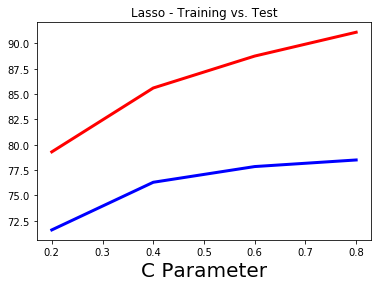

In [41]:
run_model('Lasso')

In [43]:
#Instantiate and fit
lr_lasso = LogisticRegression(penalty='l1')
train = lr_lasso.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_lasso.score(X_train, y_train))
print('\nTest set score:', lr_lasso.score(X_test, y_test))

cross_val = cross_val_score(lr_lasso, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9186666666666666

Test set score: 0.842

Cross-Validation: [0.7575 0.7975 0.7975 0.8025 0.7925]


## Conclusion
After adding new features, I saw a substantive increase in accuracy in the lasso logistic regression model.

**Original:** Training 84.86%; Test 80.40%
**Updated:** Training 91.86%; Test 84.20%